### Drug-by-drug training of best models with tuned hyperparameters

  1. perform new drug-by-drug-training and testing for the best model and calculated:
        - mae +/- std mae
        - mre +/- std mre
  2. analysis of errors
  3. feature selection with RFE
  !!!! is possible only for linear kernels
  - count features selected as important for all drugs 
  4. train and test models on the original and reduced data
        

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gc
import time

import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import MinMaxScaler

np.random.seed(123)

_FOLDER = "results/"
_FOLDER_2 = "GridSearch_results/"
_FOLDER_3 = "figures/"
csfont = {'fontname':'Times New Roman'}

In [2]:
def TrainPredict_KR(train, test, target, drug_ids_list, X_columns, kernel, hyperparameters, 
                    degree = 3, print_drug_name = True):
    y_pred = []
    for drug_id in drug_ids_list:
        if print_drug_name:
            drug_name = train.loc[drug_id, "Drug_Name"].values[0]
            print(drug_id, drug_name)
        train_drug = train.loc[drug_id,:]
        test_drug = test.loc[drug_id,:]
        y_train_drug = train_drug[target].values
        y_test_drug =  test_drug[target].values
        scaler = MinMaxScaler().fit(train_drug[X_columns])
        Xtrain_drug = scaler.transform(train_drug[X_columns])
        
        model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters.loc[drug_id, "best_coef03"], 
                        degree = hyperparameters.loc[drug_id, "best_degree3"])
        model.fit(Xtrain_drug, y_train_drug)
        Xtest_drug = scaler.transform(test_drug[X_columns])
        
        y_pred.extend(model.predict(Xtest_drug))
    return y_pred

def TrainTest_KR(train, test, target, drug_ids_list, X_columns, kernel, hyperparameters, 
                    degree = 3, print_drug_name = True):
    
    y_pred = TrainPredict_KR(train_df_50, test_df_50, 
                                       target = target, drug_ids_list =drug_ids_list, 
                                       X_columns = X_columns, kernel = kernel, 
                                       hyperparameters= hyperparameters, print_drug_name = print_drug_name)

    abs_errors = abs(test_df_50[target] - y_pred)    
    rel_errors = abs(test_df_50[target] - y_pred)*100/test_df_50[target] 

    print("\nMAE:", round(abs_errors.mean(), 3), "+/-", round(abs_errors.std(), 3))
    print("MRE:", round(rel_errors.mean(), 1), "+/-", round(rel_errors.std(), 1))
    print("")
    print(train_df_50.shape, test_df_50.shape)
    return y_pred

### Coefficient 1 : PolynomialKernelRidge

In [3]:
hyperparameters = pd.read_csv(_FOLDER +"best_model_coef_1.csv").drop(["Unnamed: 0"], axis=1)
hyperparameters.set_index("DRUG_ID", inplace = True)
hyperparameters

,best_alpha3,best_gamma3,best_coef03,best_degree3
DRUG_ID,,,,
170,100.0,0.10000,5.0,1.0
173,100.0,0.01000,5.0,3.0
180,100.0,0.00001,0.5,1.0
200,100.0,0.00001,5.0,1.0
219,10.0,0.00001,0.5,2.0
272,500.0,0.00010,5.0,2.0
273,0.5,0.01000,1.0,1.0
274,1.0,0.00001,0.5,5.0
276,1.0,0.00001,5.0,5.0


### Reading default parameters

In [4]:
with open(_FOLDER+"X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_cell_lines = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_PubChem_properties.txt", 'r') as f:
    X_PubChem_properties = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Targets.txt", 'r') as f:
    X_targets = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Target_Pathway.txt", 'r') as f:
    X_target_pathway = [line.rstrip('\n') for line in f]
# *****************************************

all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

X_feat_dict = {"Dataset_1": X_cancer_cell_lines ,
               "Dataset_2": ["MAX_CONC"] + X_targets + X_target_pathway + X_cancer_cell_lines ,
               "Dataset_3": ["MAX_CONC"] + X_PubChem_properties +  X_cancer_cell_lines,
               "Dataset_4": ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway + X_cancer_cell_lines}

## Original training

In [5]:
with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

kernel = "polynomial"
X_columns = X_feat_dict["Dataset_4"]

y_pred = TrainTest_KR(train_df_50, test_df_50, target = "param_1", 
                      drug_ids_list =drug_ids_50, X_columns = X_columns, 
                      kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)
test_df_50["y_pred"] = y_pred
test_df_50["abs_error"]= abs(test_df_50["param_1"] - y_pred)

170 Shikonin
173 FH535
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.208 +/- 1.228
MRE: 20.9 +/- 19.0

(781, 1379) (202, 1379)


In [6]:
train_df_50["Drug_Name"].unique()

array(['Shikonin', 'FH535', 'Thapsigargin', 'Dacinostat', 'AT-7519',
       'AR-42', 'CUDC-101', 'Belinostat', 'CAY10603', 'SNX-2112',
       'THZ-2-102-1'], dtype=object)

### Analysis of MAE on drug-by-drug basis

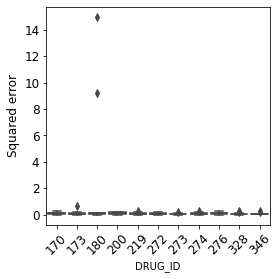

In [7]:
plt.figure(figsize=(4, 4))
sns.boxplot(x = "DRUG_ID", y = "abs_error", data = test_df_50.reset_index())

plt.xticks(rotation = 45, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Squared error", fontsize=12);

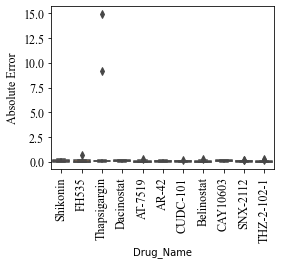

In [8]:
csfont = {'fontname':'Times New Roman'}
plt.figure(figsize=(4, 3))
sns.boxplot(x = "Drug_Name", y = "abs_error", data = test_df_50.reset_index())

plt.xticks(rotation = 90, fontsize=12, **csfont)
plt.yticks(fontsize=12, **csfont)
plt.ylabel("Absolute Error", fontsize=12, **csfont)
plt.savefig(_FOLDER_3 + "coef_1.png", bbox_inches='tight');

In [9]:
test_df_50[test_df_50["abs_error"]>8][["COSMIC_ID", "param_1", "y_pred"]]

,COSMIC_ID,param_1,y_pred
DRUG_ID,,,
180,907064,9.576391,0.348604
180,905936,15.312320,0.348623


In [10]:
test_df_50[test_df_50["COSMIC_ID"]==687777][["COSMIC_ID", "param_1", "y_pred"]]

,COSMIC_ID,param_1,y_pred
DRUG_ID,,,
173,687777,1.29139,0.623563


### Restriction on coefficient value

Restriction on coefficient value


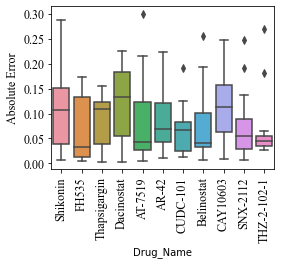

In [11]:
print("Restriction on coefficient value")
plt.figure(figsize=(4, 3))
sns.boxplot(x = "Drug_Name", y = "abs_error", data = test_df_50[test_df_50["param_1"]<=1].reset_index())

plt.xticks(rotation = 90, fontsize=12, **csfont)
plt.yticks(fontsize=12, **csfont)
plt.ylabel("Absolute Error", fontsize=12, **csfont)
plt.savefig(_FOLDER_3+"coef_1_2.png", bbox_inches='tight');

### Restriction by R2

Restriction by R2


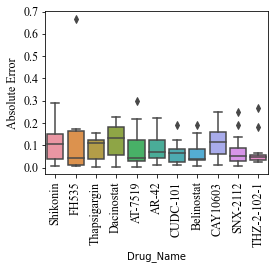

In [12]:
from sklearn.metrics import r2_score

def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
        bounds [0, 1]
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
        L<1 inverted sigmoid, l=100 - lower upper and lower boundso sigmpoid on y axis (y= [0.1, 0.11])
        bounds [0.8, 10]
    k = -1/s (s -shape parameter)  default = -10 k=0 straight line, k<0 sigmoid around k=-10
        bounds [1, -100]
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
         bounds [0, 0.9]
    parameters_bound ((0, 0.8, -100, 0), (1, 10, 1, 0.9))
    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

def r2_score_sigmoid_4_param(df, x_columns, y_columns, param_columns = []):
    r2_scores=np.zeros(len(df.index))
    for i in range(len(df.index)):
        x = df.loc[df.index[i], x_columns].values.astype(np.float32)
        y = df.loc[df.index[i], y_columns].values.astype(np.float32)
        fit_param = df.loc[df.index[i], param_columns].values.astype(np.float32)
#         print(fit_param)
        y_fit = sigmoid_4_param(x, *fit_param)
        r2_scores[i] = r2_score(y, y_fit)
    return r2_scores

test_df_50["r2_scores"] = r2_score_sigmoid_4_param(test_df_50.reset_index(), 
                                                   x_columns = ["fd_num_"+str(i) for i in range(10)],
                                                  y_columns = ["norm_cells_" + str(i) for i in range(10)],
                                                  param_columns = ["param_" + str(i) for i in range(1,5)])

print("Restriction by R2")
plt.figure(figsize=(4, 3))
sns.boxplot(x = "Drug_Name", y = "abs_error", data = test_df_50[test_df_50["r2_scores"]>0.9].reset_index())

plt.xticks(rotation = 90, fontsize=12, **csfont)
plt.yticks(fontsize=12,**csfont)
plt.ylabel("Absolute Error", fontsize=12,**csfont)
plt.savefig(_FOLDER_3+ "coef_1_3.png", bbox_inches='tight');


## Retraining the model on the new data: Restriction for Coefficient

### Restriction in place for the ready data

In [13]:
del train_df_50
del test_df_50

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

train_df_50 = train_df_50[train_df_50["param_1"]<1].copy()
test_df_50 = test_df_50[test_df_50["param_1"]<1].copy()

y_pred = TrainTest_KR(train_df_50, test_df_50, target = "param_1", drug_ids_list =drug_ids_50, 
             X_columns = X_columns, kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)

170 Shikonin
173 FH535
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.129 +/- 0.097
MRE: 28.0 +/- 20.1

(765, 1379) (199, 1379)


### New data set with the restriction for coefficients

In [14]:
del train_df_50
del test_df_50

with open(_FOLDER + "drug_ids_50_restr_coef.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER+"train08_min10_restr_coef.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_min10_restr_coef.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

y_pred = TrainTest_KR(train_df_50, test_df_50, target = "param_1", drug_ids_list =drug_ids_50, 
             X_columns = X_columns, kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)

170 Shikonin
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.135 +/- 0.094
MRE: 30.8 +/- 20.6

(588, 1380) (152, 1380)


## Retraining the model on the new data: Restriction for R2

170 Shikonin
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.134 +/- 0.095
MRE: 28.8 +/- 19.7

(723, 1380) (185, 1380)
Restriction by R2


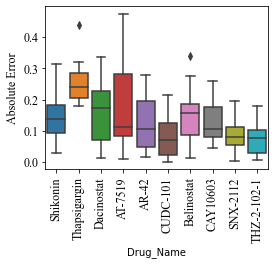

In [15]:
del train_df_50
del test_df_50

with open("results/drug_ids_50_restr.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    

train_df = pd.read_csv("results/train08_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv("results/test02_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

y_pred = TrainTest_KR(train_df_50, test_df_50, target = "param_1", 
                      drug_ids_list =drug_ids_50, X_columns = X_columns, 
                      kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)

test_df_50["abs_error"]= abs(test_df_50["param_1"] - y_pred)

print("Restriction by R2")
plt.figure(figsize=(4, 3))
sns.boxplot(x = "Drug_Name", y = "abs_error", data = test_df_50.reset_index())

plt.xticks(rotation = 90, fontsize=12,**csfont)
plt.yticks(fontsize=12,**csfont)
plt.ylabel("Absolute Error", fontsize=12,**csfont)
plt.savefig(_FOLDER_3+"coef_1_4.png", bbox_inches='tight');

## Feature importance

RFE feature selection is possible only for the linear kernel!!!
<br>Therefore we need to read the data with the best hyperparameters for linear model
The best variant seems to be SVR Linear

In [16]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

df = pd.read_csv(_FOLDER_2+ "Linear_SVR_coef1.csv").rename(columns={"Unnamed: 0": "DRUG_ID"})
hyperparameters_rfe = pd.read_csv(_FOLDER_2+ "Linear_SVR_coef1.csv").rename(columns={"Unnamed: 0": "DRUG_ID"})[['DRUG_ID', 'best_C3', 'best_epsilon3']].set_index("DRUG_ID")
# best.to_csv(_FOLDER+"best_model_coef_" +str(i)+ ".csv")
hyperparameters_rfe

,best_C3,best_epsilon3
DRUG_ID,,
170,0.01,0.100
173,0.01,0.001
180,0.01,0.001
200,0.01,0.001
219,0.01,0.100
272,0.01,0.100
273,0.01,0.010
274,0.01,0.100
276,0.01,0.001


## RFE on the original data

In [17]:
del train_df_50
del test_df_50

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]


all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

df_features = pd.DataFrame(index=drug_ids_50)
most_important = {}

for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_1"].values
    y_test_drug =  test_drug["param_1"].values
    
    X_columns = X_feat_dict["Dataset_4"]
    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    estimator = SVR(kernel = "linear", 
                    C = hyperparameters_rfe.loc[drug_id, 'best_C3'],
                    epsilon = hyperparameters_rfe.loc[drug_id,'best_epsilon3'])
    # feature selector
    selector = RFE(estimator, n_features_to_select=50, step=10)
    selector = selector.fit(Xtrain_drug, y_train_drug)
    most_important[drug_id] = np.array(X_columns)[selector.support_]
    
    #models parameters
    estimator.fit(Xtrain_drug, y_train_drug)
    df_features.loc[drug_id, "zero"] = len(estimator.coef_[estimator.coef_==0])
    df_features.loc[drug_id, "max"] = round(abs(estimator.coef_[0]).max(),3)
    df_features.loc[drug_id, "more_0_01"] =sum(abs(estimator.coef_[0])>0.01)
    
df_features["zero"] = df_features["zero"].astype('int32')
df_features["more_0_01"] = df_features["more_0_01"].astype('int32')
display(df_features)

display(pd.DataFrame(data= [int(df_features["zero"].mean()), df_features["max"].max(), int(df_features["more_0_01"].mean())]).T)

,zero,max,more_0_01
170,703,0.023,41
173,766,0.025,44
180,716,0.029,85
200,660,0.028,53
219,986,0.015,17
272,858,0.017,20
273,616,0.025,67
274,885,0.015,9
276,627,0.031,95
328,562,0.022,50


,0,1,2
0,793.0,0.031,43.0


In [18]:
all_features = []
for key in most_important.keys():
    all_features.extend(most_important[key])
most_important_features = set(all_features)
len(all_features), len(most_important_features)

df_features = pd.DataFrame(index = list(most_important_features), columns = drug_ids_50)
for drug_id in drug_ids_50:
    df_features[drug_id] = 0
    df_features.loc[most_important[drug_id], drug_id]=1

df_features["sum"]= df_features[drug_ids_50].sum(axis=1)
df_features.sort_values("sum", ascending = False)

from_CCLE = set(most_important_features)& set(X_cancer_cell_lines)
print("from CCL:", len(set(most_important_features)& set(X_cancer_cell_lines)))
print("from PubChem_properties",len( set(most_important_features)& set(X_PubChem_properties)))
print("from targets:", len(set(most_important_features)& set(X_targets)))
print("from target pathway:", len(set(most_important_features)& set(X_target_pathway)))

from CCL: 322
from PubChem_properties 0
from targets: 31
from target pathway: 0


## RFE on the reduced by R2 data

In [19]:
del train_df_50
del test_df_50

with open("results/drug_ids_50_restr.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

# reduced by R2 filtration criteria    
train_df = pd.read_csv("results/train08_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv("results/test02_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

df_features_2 = pd.DataFrame(index=drug_ids_50)
most_important_2 = {}
for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_1"].values
    y_test_drug =  test_drug["param_1"].values
    
#     print(drug_id, drug_name, len(X_columns))
    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    estimator = SVR(kernel = "linear", 
                    C = hyperparameters_rfe.loc[drug_id, 'best_C3'],
                    epsilon = hyperparameters_rfe.loc[drug_id,'best_epsilon3'])
    estimator.fit(Xtrain_drug, y_train_drug)
    df_features_2.loc[drug_id, "zero"] = len(estimator.coef_[estimator.coef_==0])
    df_features_2.loc[drug_id, "max"] = round(abs(estimator.coef_[0]).max(),3)
    df_features_2.loc[drug_id, "more_0_01"] =sum(abs(estimator.coef_[0])>0.01)

df_features_2["zero"] = df_features_2["zero"].astype('int32')
df_features_2["more_0_01"] = df_features_2["more_0_01"].astype('int32')
display(df_features_2)

display(pd.DataFrame(data= [int(df_features_2["zero"].mean()), df_features_2["max"].max(), int(df_features_2["more_0_01"].mean())]).T)

,zero,max,more_0_01
170,709,0.022,17
180,742,0.034,44
200,663,0.025,60
219,987,0.021,6
272,827,0.009,0
273,637,0.027,54
274,931,0.014,8
276,626,0.032,102
328,561,0.021,45
346,1352,0.000,0


,0,1,2
0,803.0,0.034,33.0


## Train on the reduced data: Restriction for R2 and top50 features subset 

In [20]:
def TrainPredict_KR_subset(train, test, target, drug_ids_list, subset_feat_dict, kernel, hyperparameters, 
                    degree = 3, print_drug_name = True):
    y_pred = []
    for drug_id in drug_ids_list:
        if print_drug_name:
            drug_name = train.loc[drug_id, "Drug_Name"].values[0]
            print(drug_id, drug_name)
        train_drug = train.loc[drug_id,:]
        test_drug = test.loc[drug_id,:]
        y_train_drug = train_drug[target].values
        y_test_drug =  test_drug[target].values
        X_columns = subset_feat_dict[drug_id]
        scaler = MinMaxScaler().fit(train_drug[X_columns])
        Xtrain_drug = scaler.transform(train_drug[X_columns])
        
        model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters.loc[drug_id, "best_coef03"], 
                        degree = hyperparameters.loc[drug_id, "best_degree3"])
        model.fit(Xtrain_drug, y_train_drug)
        Xtest_drug = scaler.transform(test_drug[X_columns])
        
        y_pred.extend(model.predict(Xtest_drug))
    return y_pred

def TrainTest_KR_subset(train, test, target, drug_ids_list, subset_feat_dict, kernel, hyperparameters, 
                    degree = 3, print_drug_name = True):
    
    y_pred = TrainPredict_KR_subset(train_df_50, test_df_50, 
                                       target = target, drug_ids_list =drug_ids_50, 
                                       subset_feat_dict = subset_feat_dict, kernel = kernel, 
                                       hyperparameters= hyperparameters, print_drug_name = print_drug_name)

    abs_errors = abs(test_df_50[target] - y_pred)    
    rel_errors = abs(test_df_50[target] - y_pred)*100/test_df_50[target] 

    print("\nMAE:", round(abs_errors.mean(), 3), "+/-", round(abs_errors.std(), 3))
    print("MRE:", round(rel_errors.mean(), 1), "+/-", round(rel_errors.std(), 1))
    print("")
    print(train_df_50.shape, test_df_50.shape)
    return y_pred

In [21]:
del train_df_50
del test_df_50

with open("results/drug_ids_50_restr.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

# reduced by R2 filtration criteria    
train_df = pd.read_csv("results/train08_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv("results/test02_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

y_pred = TrainTest_KR_subset(train_df_50, test_df_50, target = "param_1", drug_ids_list =drug_ids_50, 
             subset_feat_dict = most_important, kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)

170 Shikonin
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.13 +/- 0.094
MRE: 28.1 +/- 19.6

(723, 1380) (185, 1380)


## Training on the original data and feature subset

In [22]:
del train_df_50
del test_df_50

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

y_pred = TrainTest_KR_subset(train_df_50, test_df_50, target = "param_1", drug_ids_list =drug_ids_50, 
             subset_feat_dict = most_important, kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)

170 Shikonin
173 FH535
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.207 +/- 1.228
MRE: 20.7 +/- 18.7

(781, 1379) (202, 1379)
